## Why Build off of DifferentialEquations.jl

In order to scale to the next generation of PKPD software, we need:

- More efficiency
- Abstract typing (higher precision, uncertainty propogation, GPU support)
- Enhanced verification
- Support for a large class of differential equations (ODEs/SDEs/DDEs/PDEs)
  - More realistic models

DifferentialEquations.jl is a software suite which mixes classic with hundreds of unique and efficient native Julia implementations to give these features.

## Efficiency

- Classic methods used by other (PK/PD) modeling software such as CVODE and LSODA are available
- Newer methods from recent research have Julia implementations and can be more much more efficient
- DifferentialEquations.jl has hundreds of methods which are specialized to different problem domains

All methods are available for PK/PD simulations, but unique methods have been chosen as the default due to the efficiency in this domain. Let's look at one example of how we can improve over previous methods:

### Example: Rodas5 vs BDF (GEAR) Methods on Stiff Chemical Reaction Networks

High order Rosenbrock methods can take less work to reach the same amount of error on small (<100 ODEs) reaction networks of PK/PD simulations.

In [1]:
using OrdinaryDiffEq, DiffEqProblemLibrary, Sundials
gr()
prob = prob_ode_rober 
prob = ODEProblem(prob_ode_rober.f,prob_ode_rober.u0,(0.0,1e5))
sol = solve(prob,CVODE_BDF(),abstol=1/10^14,reltol=1/10^14)
test_sol = TestSolution(sol)

abstols = 1./10.^(7:12)
reltols = 1./10.^(4:9)
setups = [
          Dict(:alg=>CVODE_BDF()),
          Dict(:alg=>Rodas5())]
names = ["Rodas5" "CVODE_BDF"]
wp = WorkPrecisionSet(prob,abstols,reltols,setups;names=names,
                      save_everystep=false,appxsol=test_sol,maxiters=Int(1e5))
plot(wp)

LoadError: [91mArgumentError: Module DiffEqProblemLibrary not found in current path.
Run `Pkg.add("DiffEqProblemLibrary")` to install the DiffEqProblemLibrary package.[39m

BDF methods are the most common stiff integrator in PK/PD software, but are inefficient when there are lots of events.

In [2]:
using OrdinaryDiffEq, Sundials


callback_f = function (du, u, p, t)
  du[1] = u[2]
  du[2] = -9.81
end

condtion= function (u,t,integrator) # Event when event_f(u,t,k) == 0
  u[1]
end

affect! = nothing
affect_neg! = function (integrator)
  integrator.u[2] = -integrator.u[2]
end

callback = ContinuousCallback(condtion,affect!,affect_neg!)

u0 = [50.0,0.0]
tspan = (0.0,15.0)
prob = ODEProblem(callback_f,u0,tspan)

DiffEqBase.ODEProblem with uType Array{Float64,1} and tType Float64. In-place: true
timespan: (0.0, 15.0)
u0: [50.0, 0.0]

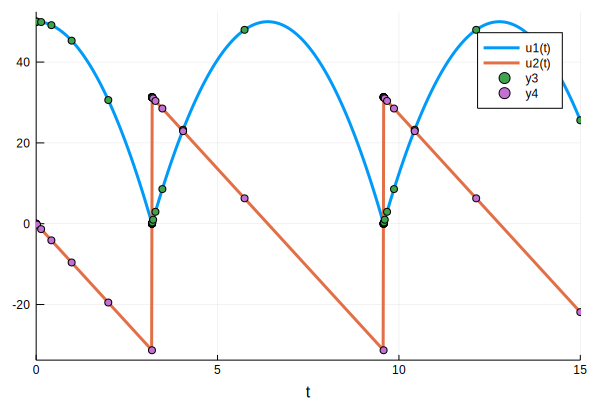

In [3]:
sol = solve(prob,CVODE_BDF(),callback=callback);
println("A standard BDF (GEAR) implementation (CVODE) takes $(length(sol)) steps")
using Plots; gr()
plot(sol);
scatter!(sol.t,sol[1,:])
scatter!(sol.t,sol[2,:])

A high order Rosenbrock method (Rodas5) takes 9 steps


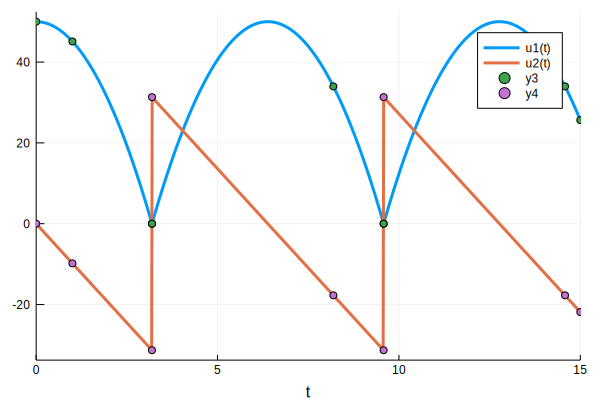

In [4]:
sol = solve(prob,Rodas5(),callback=callback,dt=1.0,dtmax=5.0)
println("A high order Rosenbrock method (Rodas5) takes $(length(sol)) steps")
using Plots; gr()
plot(sol);
scatter!(sol.t,sol[1,:])
scatter!(sol.t,sol[2,:])

## Abstract Typing

Abstract typing means that arbitrary number and data types work inside the integration routines. Here's a few examples of types which can be useful for PK/PD modeling.

## Arbitrary Precision Numbers for High Accuracy

Test and verify solutions well-beyond the accuracy of 64-bit floating point numbers to ensure correctness

In [1]:
using OrdinaryDiffEq
f = (u,p,t) -> (big(1.01)*u)
prob = ODEProblem(f,big(1/2),big.((0.0,1.0)))
sol = solve(prob,Vern9(),reltol=1e-16)
sol[end]

1.372800507514090983333681728692462653836655375979175341612650059174041994481800

## Set Arithmetic and Uncertainty Propagation

Propagate numerical uncertainties to get accurate bounds on measured quantities

In [4]:
using OrdinaryDiffEq, Measurements

g = 9.79 ± 0.02; # Gravitational constants
L = 1.00 ± 0.01; # Length of the pendulum

#Initial Conditions
u₀ = [0 ± 0, π / 3 ± 0.02] # Initial speed and initial angle
tspan = (0 ± 0, 6.3 ± 0)

#Define the problem
function simplependulum(du,u,p,t)
    θ  = u[1]
    dθ = u[2]
    du[1] = dθ
    du[2] = -(g/L) * sin(θ)
end

#Pass to solvers
prob = ODEProblem(simplependulum, u₀, tspan)
sol = solve(prob, Tsit5())
println("The location of the pendulum is: $(sol[1,end])")
println("The velocity of the pendulum is: $(sol[2,end])")

The location of the pendulum is: 0.2231828262775308 ± 0.024532901144010147
The velocity of the pendulum is: 0.7821063907892316 ± 0.07304019254780464


## Unitful Arithmetic

Units are computed during compilation, meaning that there is no runtime cost for using units. This allows for automatic conversions and automatic dimensional analysis checks.

In [6]:
using OrdinaryDiffEq, Unitful
f = (y,p,t) -> 0.5*y/3.0u"s"
prob = ODEProblem(f,5.0u"kg",(0.0u"s",1.0u"s"))
sol = solve(prob,Tsit5())
println(sol.t[end])
sol[end]

LoadError: [91mDimensionError: 0.8568973684710053 s and 2.220446049250313e-15 are not dimensionally compatible.[39m

## GPUs and Distributed Parallelism

Easily utilize GPU acceleration and parallelize across large compute clusters / cloud services (AWS)

In [ ]:
# Full example at http://www.stochasticlifestyle.com/solving-systems-stochastic-pdes-using-gpus-julia/
# Define a bunch of constants for the PDE Discretization

# Now make the arrays on the GPU
using CLArrays
gA = CLArray(A); gB  = CLArray(B); gC = CLArray(C)
const gMx = CLArray(Mx)
const gMy = CLArray(My)
const gα₁ = CLArray(α₁)
gu0 = ArrayPartition((gA,gB,gC))
 
const gMyA = zeros(N,N)
const gAMx = zeros(N,N)
const gDA = zeros(N,N)

# Write standard vectorized code
function gf(du,u,p,t)
  A,B,C = u.x
  dA,dB,dC = du.x
  A_mul_B!(gMyA,gMy,A)
  A_mul_B!(gAMx,A,gMx)
  @. DA = D*(gMyA + AgMx)
  @. dA = DA + gα₁ - β₁*A - r₁*A*B + r₂*C
  @. dB = α₂ - β₂*B - r₁*A*B + r₂*C
  @. dC = α₃ - β₃*C + r₁*A*B - r₂*C
end

# Solve on the GPU
prob2 = ODEProblem(gf,gu0,(0.0,100.0))
sol = solve(prob2,BS3(),progress=true,dt=0.003,adaptive=false,save_everystep=false,save_start=false)

## Enhanced Verification

JuliaDiffEq's features and development style allows for highly precise verification of solution accuracy:

- The hundreds of methods allow for cross-verification that solutions converge to the same result
    - DifferentialEquations.jl includes wrappers most of the classic non-Julia methods
- Arbitrary precision arithmetic is utilized to test against analytical solutions and generate high accuracy reference results
- Continuous integration has unit tests for convergence, interpolation accuracy, and event accuracy of every method for every commit
    - A secondary CI setup is a community-driven test suite to check the precision on astrophysical, quantum particle, ecological, etc. models
- Open issue tracker and chatrooms allow for free flow of information, making it easy to utilize community resources to identify and solve bugs.

## Large Choice of Modeling Equations

DifferentialEquations.jl is not just for ODEs. It has state-of-the-art methods for a large range of mathematical models available.

## High Order Adaptive Integrators for Stochastic Differential Equations (SDEs)

These are unique to DifferentialEquations.jl and have been demonstrated as to be >6,000x more efficient on stochastic chemical reaction networks

In [7]:
using StochasticDiffEq
function lorenz(du,u,p,t)
  du[1] = 10.0(u[2]-u[1])
  du[2] = u[1]*(28.0-u[3]) - u[2]
  du[3] = u[1]*u[2] - (8/3)*u[3]
end

function σ_lorenz(du,u,p,t)
  du[1] = 3.0
  du[2] = 3.0
  du[3] = 3.0
end

prob_sde_lorenz = SDEProblem(lorenz,σ_lorenz,[1.0,0.0,0.0],(0.0,10.0))
sol = solve(prob_sde_lorenz,SRIW1())
using Plots; gr()
plot(sol,vars=(1,2,3))

<?xml version="1.0" encoding="utf-8"?>
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
<polyline clip-path="url(#clip5900)" style="stroke:#000000; stroke-width:1; stroke-opacity:1; fill:none" points="
 126.207,354.363 126.207,354.363 123.542,355.653 126.207,354.363 126.207,319.608 124.874,320.254 126.207,319.608 126.207,284.854 123.542,286.145 126.207,284.854 
 126.207,250.1 124.874,250.745 126.207,250.1 126.207,215.346 123.542,216.636 126.207,215.346 126.207,180.592 124.874,181.237 126.207,180.592 126.207,145.837 
 123.542,147.128 126.207,145.837 126.207,111.083 124.874,111.728 126.207,111.083 126.207,76.329 123.542,77.6193 126.207,76.329 
 "/>
 
 
 
 
 
 
 
 
<polyline clip-path="url(#clip5900)" style="stroke:#000000; stroke-width:1; stroke-opacity:1; fill:none" points="
 126.207,354.363 145.083,356.122 143.751,356.767 145.083,356.122 172.776,358.702 170.111,359.992 172.776,358.702 200.469,361.282 199.136,361.927 200.469,361.282 
 228.162,363.863 225.496,365.153 228.162,363.863 255.854,366.443 254.522,367.088 255.854,366.443 283.547,369.023 280.882,370.314 283.547,369.023 311.24,371.604 
 309.907,372.249 311.24,371.604 338.933,374.184 336.267,375.475 338.933,374.184 357.01,375.869 
 "/>
 
 
 
 
<polyline clip-path="url(#clip5902)" style="stroke:#009af9; stroke-width:3; stroke-opacity:1; fill:none" points="
 286.762,269.179 286.772,269.115 286.824,269.128 286.871,269.132 286.833,269.135 286.818,269.167 286.821,269.187 286.871,269.156 286.846,269.229 286.641,269.372 
 286.625,269.35 286.683,269.195 286.508,269.238 286.548,269.165 286.604,269.159 286.636,269.123 286.605,269.27 286.432,269.207 286.682,269.282 286.479,269.256 
 286.494,269.164 286.413,268.992 286.414,268.774 286.231,268.64 286.329,268.808 286.294,268.75 286.59,268.89 286.528,268.692 287.279,268.63 287.582,268.324 
 287.091,268.405 286.599,268.564 287.137,268.532 287.475,268.507 287.958,268.959 287.865,268.621 287.998,268.443 287.647,268.518 288.043,268.535 288.309,268.31 
 287.891,269.081 287.814,268.744 287.502,268.512 286.575,268.73 286.826,268.662 286.449,268.734 286.814,268.852 287.043,268.415 287.231,268.497 288.166,268.446 
 288.226,268.084 288.047,268.145 286.996,268.03 286.481,267.952 285.014,267.978 285.556,267.654 285.858,267.866 285.529,267.123 285.219,267.199 285.369,266.294 
 285.547,266.981 286.069,267.543 286.896,267.257 287.682,267.533 288.658,267.346 290.713,267.102 289.924,266.722 289.927,266.275 289.291,266.089 289.974,264.93 
 290.528,264.872 291.908,265.414 290.353,265.918 290.771,266.136 290.775,266.651 290.314,267.721 291.882,268.83 293.336,268.934 292.354,268.031 291.278,268.964 
 291.657,269.222 293.618,269.309 293.337,268.858 293.95,268.506 293.01,267.992 291.835,268.339 291.708,269.239 290.56,269.219 291.509,269.361 292.242,269.092 
 293.448,269.269 292.533,269.229 291.361,269.64 290.018,269.78 290.955,269.946 292.44,269.867 292.388,269.986 292.629,268.927 293.41,269.151 295.5,267.639 
 295.486,267.714 295.526,267.737 295.829,268.585 296.519,268.741 296.493,268.467 296.855,268.127 297.234,267.817 298.318,268.291 299.045,268.901 300.837,268.468 
 300.646,268.233 299.766,268.558 300.391,267.615 302.566,267.763 303.69,267.694 304.2,268.015 304.59,267.828 304.025,267.491 305.579,266.807 307.572,265.792 
 307.442,265.261 307.374,266.412 308.438,265.8 308.354,265.334 309.217,264.747 310.31,264.641 310.528,264.408 311.726,264.034 313.161,263.774 314.996,263.133 
 315.294,263.596 315.973,263.41 315.575,262.681 316.01,261.881 317.343,261.289 317.68,260.809 318.277,261.357 318.474,261.888 320.377,261.546 320.742,261.355 
 321.156,260.978 322.195,260.854 322.421,259.772 322.4,260.065 322.967,259.72 323.502,259.088 324.65,258.74 324.996,259.145 326.217,259.17 326.815,259.176 
 327.385,259.098 327.766,259.026 329.086,258.688 329.258,258.364 330.208,257.822 330.239,257.881 330.65,257.641 331.009,257.239 331.511,257.112 332.503,256.512 
 332.923,256.479 333.226

## High Order Semi-Implicit Integrators for Stiff Delay Differential Equations (DDEs)

In [8]:
using DelayDiffEq, DiffEqDevTools, DiffEqProblemLibrary, Plots
sol = solve(prob_dde_qs, MethodOfSteps(Rodas4()))
plot(sol)

INFO: Precompiling module DelayDiffEq.
INFO: Precompiling module DiffEqDevTools.


LoadError: [91mArgumentError: Module DiffEqProblemLibrary not found in current path.
Run `Pkg.add("DiffEqProblemLibrary")` to install the DiffEqProblemLibrary package.[39m

## Mixed Discrete Markov Chains with Stochastic Differential Equations (Jump Diffusions)

Model time-dependence of rates between Pk and Pd components, mixing discrete and continuous evolution models.

In [17]:
using DiffEqJump, StochasticDiffEq

rate1(u,p,t) = (0.1/100.0)*u[1]*u[2]
function affect1!(integrator)
  integrator.u[1] -= 1
  integrator.u[2] += 1
end
jump = ConstantRateJump(rate1,affect1!)

rate2(u,p,t) = 0.01u[2]
function affect2!(integrator)
  integrator.u[2] -= 1
  integrator.u[3] += 1
end
jump2 = ConstantRateJump(rate2,affect2!)

function f2(du,u,p,t)
  du[4] = u[2]*u[3]/10000 - u[1]*u[2]/10000
end
function g2(du,u,p,t)
  du[4] = 0.1u[4]
end

prob = SDEProblem(f2,g2,[99.0,1.0,0.0,1.0],(0.0,250.0))
jump_prob = JumpProblem(prob,Direct(),jump,jump2,jump3)
srand(100)
sol = solve(jump_prob,SRIW1())
plot(sol)

<?xml version="1.0" encoding="utf-8"?>
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 0 
 
 
 50 
 
 
 100 
 
 
 150 
 
 
 200 
 
 
 250 
 
 
 0 
 
 
 20 
 
 
 40 
 
 
 60 
 
 
 80 
 
 
 t 
 
<polyline clip-path="url(#clip7302)" style="stroke:#009af9; stroke-width:3; stroke-opacity:1; fill:none" points="
 29.1292,11.811 29.1469,11.811 29.1668,11.811 29.1891,11.811 29.2143,11.811 29.2426,11.811 29.2745,11.811 29.3103,11.811 29.3506,11.811 29.396,11.811 
 29.447,11.811 29.5044,11.811 29.569,11.811 29.6416,11.811 29.7234,11.811 29.8153,11.811 29.9187,11.811 30.0351,11.811 30.166,11.811 30.3133,11.811 
 30.479,11.811 30.6654,11.811 30.8751,11.811 31.111,11.811 31.3764,11.811 31.675,11.811 32.0109,11.811 32.3887,11.811 32.8139,11.811 33.2921,11.811 
 33.8302,11.811 34.4355,11.811 35.1164,11.811 35.8825,11.811 36.7443,11.811 37.7139,11.811 38.8047,11.811 40.0318,11.811 41.4123,11.811 42.9654,11.811 
 44.5487,11.811 44.5487,15.1003 46.3301,15.1003 48.334,15.1003 49.9494,15.1003 49.9494,18.3896 51.7666,18.3896 52.7811,18.3896 52.7811,21.6789 53.9223,21.6789 
 55.1886,21.6789 56.6133,21.6789 56.6565,21.6789 56.6565,24.9682 56.7052,24.9682 56.7599,24.9682 56.8215,24.9682 56.8907,24.9682 56.9687,24.9682 57.0563,24.9682 
 57.155,24.9682 57.2659,24.9682 57.3532,24.9682 57.3532,28.2575 57.4515,28.2575 57.562,28.2575 57.6863,28.2575 57.8261,28.2575 57.9835,28.2575 58.1152,28.2575 
 58.1152,31.5468 58.2635,31.5468 58.4303,31.5468 58.5278,31.5468 58.5278,34.8361 58.6375,34.8361 58.761,34.8361 58.8998,34.8361 59.056,34.8361 59.2318,34.8361 
 59.4295,34.8361 59.6519,34.8361 59.9022,34.8361 60.1837,34.8361 60.5004,34.8361 60.8567,34.8361 60.9327,34.8361 60.9327,38.1254 61.0182,38.1254 61.1145,38.1254 
 61.2227,38.1254 61.3445,38.1254 61.4815,38.1254 61.6357,38.1254 61.8091,38.1254 62.0041,38.1254 62.2236,38.1254 62.4705,38.1254 62.7483,38.1254 63.0607,38.1254 
 63.1707,38.1254 63.1707,41.4147 63.2944,41.4147 63.4335,41.4147 63.59,41.4147 63.7469,41.4147 63.7469,44.704 63.9233,44.704 64.0897,44.704 64.0897,47.9933 
 64.2769,47.9933 64.4875,47.9933 64.7244,47.9933 64.991,47.9933 65.037,47.9933 65.037,51.2825 65.0888,51.2825 65.1471,51.2825 65.2127,51.2825 65.2864,51.2825 
 65.3694,51.2825 65.4628,51.2825 65.5678,51.2825 65.6859,51.2825 65.8188,51.2825 65.9684,51.2825 66.1366,51.2825 66.3258,51.2825 66.5337,51.2825 66.5337,54.5718 
 66.7675,54.5718 66.7754,54.5718 66.7754,57.8611 66.7843,57.8611 66.7944,57.8611 66.8057,57.8611 66.8184,57.8611 66.8327,57.8611 66.8488,57.8611 66.8669,57.8611 
 66.8873,57.8611 66.9102,57.8611 66.936,57.8611 66.965,57.8611 66.9977,57.8611 67.0344,57.8611 67.0757,57.8611 67.1222,57.8611 67.1745,57.8611 67.2333,57.8611 
 67.2995,57.8611 67.3579,57.8611 67.3579,61.1504 67.4237,61.1504 67.4977,61.1504 67.581,61.1504 67.6746,61.1504 67.7529,61.1504 67.7529,64.4397 67.8409,64.4397 
 67.9399,64.4397 68.0512,64.4397 68.1766,64.4397 68.3175,64.4397 68.4761,64.4397 68.6545,64.4397 68.8552,64.4397 69.0811,64.4397 69.154,64.4397 69.154,67.729 
 69.2361,67.729 69.3285,67.729 69.4323,67.729 69.5492,67.729 69.6807,67.729 69.8286,67.729 69.995,67.729 70.0569,67.729 70.0569,71.0183 70.1265,71.0183 
 70.2048,71.0183 70.2929,71.0183 70.392,71.0183 70.5034,71.0183 70.6288,71.0183 70.7699,71.0183 70.9286,71.0183 71.1072,71.0183 71.3081,71.0183 71.4981,71.0183 
 71.4981,74.3076 71.712,74.3076 71.9525,74.3076 72.2232,74.3076 72.5276,74.3076 72.8678,74.3076 73.2506,74.3076 73.6516,74.3076 73.9078,74.3076 73.9078,77.5969 
 74.1959,77.5969 74.52,77.5969 74.8453,77.5969 74.8453,80.8862 75.2113,80.8862 75.3644,80.8862 75.3644,84.1755 75.5367,84.1755 75.7306,84.1755 75.9487,84.1755 
 76.194,84.1755 76.47,84.1755 76.7805,84.1755 77.1298,84.1755 77.5227,84.1755 77.6567,84.1755 77.6567,87.4648 77.8075,87.4648 77.9771,87.4648 78.1678,87.4648 
 78.3097,87.4648 78.3097,90.7541 78.4558,90.7541 78.4558,94.0434 78.6201,94.0434 78.805,94.0434 78.9858,94.0434 78.9858,97.3327 79.1892,97.3327 79.4181,97.3327 
 79.6756,97.

## Reaction-Diffusion-Advection PDEs

Model chemical reaction networks with spatial relations via PDEs

In [ ]:
using OrdinaryDiffEq, RecursiveArrayTools
 
# Define the constants for the PDE
const α₂ = 1.0
const α₃ = 1.0
const β₁ = 1.0
const β₂ = 1.0
const β₃ = 1.0
const r₁ = 1.0
const r₂ = 1.0
const D = 100.0
const γ₁ = 0.1
const γ₂ = 0.1
const γ₃ = 0.1
const N = 100
const X = reshape([i for i in 1:100 for j in 1:100],N,N)
const Y = reshape([j for i in 1:100 for j in 1:100],N,N)
const α₁ = 1.0.*(X.>=80)
 
const Mx = full(Tridiagonal([1.0 for i in 1:N-1],[-2.0 for i in 1:N],[1.0 for i in 1:N-1]))
const My = copy(Mx)
Mx[2,1] = 2.0
Mx[end-1,end] = 2.0
My[1,2] = 2.0
My[end,end-1] = 2.0
 
# Define the initial condition as normal arrays
A = zeros(N,N); B  = zeros(N,N); C = zeros(N,N)
u0 = ArrayPartition((A,B,C))
 
const MyA = zeros(N,N);
const AMx = zeros(N,N);
const DA = zeros(N,N)
# Define the discretized PDE as an ODE function
function rd(du,u,p,t)
  A,B,C = u.x
  dA,dB,dC = du.x
  A_mul_B!(MyA,My,A)
  A_mul_B!(AMx,A,Mx)
  @. DA = D*(MyA + AMx)
  @. dA = DA + α₁ - β₁*A - r₁*A*B + r₂*C
  @. dB = α₂ - β₂*B - r₁*A*B + r₂*C
  @. dC = α₃ - β₃*C + r₁*A*B - r₂*C
end
 
# Solve the ODE
prob = ODEProblem(rd,u0,(0.0,100.0))
sol = solve(prob,BS3(),progress=true,save_everystep=false,save_start=false)
 
using Plots; gr()
surface(X[1,:],Y[:,1],sol[end].x[1],title = "[A]")